<a href="https://colab.research.google.com/github/MSHQD/HWR/blob/main/model_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install hwb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.7 MB/s eta 0:00:00


# **Settings**

In [3]:
!pip install transformers -q
!pip install -q datasets jiwer
!pip install sentencepiece -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.8 MB/s eta 0:00:00


In [4]:
!ls -hl

total 8.0K
drwx------ 6 root root 4.0K May 29 07:46 drive
drwxr-xr-x 1 root root 4.0K May 23 13:39 sample_data


In [5]:
!git clone https://github.com/microsoft/unilm
!cp unilm/trocr/data_aug.py data_aug.py

Cloning into 'unilm'...
remote: Enumerating objects: 11087, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 11087 (delta 30), reused 18 (delta 18), pack-reused 11048 (from 2)
Receiving objects: 100% (11087/11087), 67.98 MiB | 11.05 MiB/s, done.
Resolving deltas: 100% (5289/5289), done.
Updating files: 100% (5993/5993), done.


In [6]:
import cv2
import random
import json
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
import torch, torchvision
import warnings
from skimage import io
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torchvision
from torch.nn.utils.rnn import pad_sequence

warnings.filterwarnings("ignore")
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import shutil
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms


In [7]:
import torch
from torch import nn

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [8]:
SEED = 42
def set_seed(seed: int = 42, set_torch=True):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    if set_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed(SEED)

# **Global variables**

In [9]:
DATA_DIR = "/content/train_recognition_small"
TRAIN_DIR = "/content/train_recognition_small/images"
# TRAIN_DIR = '/content/data'
PROJECT_DIR = '/content/drive/MyDrive'
MODEL_DIR = os.path.join(PROJECT_DIR, 'segmentation_models')
TRAIN_BATCH_SIZE = 10
model_type = 'small'
VAL_BATCH_SIZE = 64
img_size = (384, 384) #(256, 256) #

# **Load datasets**

In [10]:
import zipfile
zip1 = '/content/drive/MyDrive/train_recognition_small.zip'
extract_to1 = '/content/train_recognition_small'

with zipfile.ZipFile(zip1, 'r') as zip_ref:
    zip_ref.extractall(extract_to1)

In [11]:
hack_data = pd.read_json('train_recognition_small/train_recognition_small/labels_small.json')
hack_data = hack_data.rename(columns={
    'file_name': 'image',
    'text': 'label'
})

In [12]:
print(hack_data.head())

   image     label base_image
0  0.png   дверку,    1_5.JPG
1  1.png    открыл    1_5.JPG
2  2.png         Я    1_5.JPG
3  3.png  хвостом.    1_5.JPG
4  4.png     вилял    1_5.JPG


In [13]:
from pathlib import Path

hack_data['image'] = hack_data['image'].apply(lambda x: os.path.join('train_recognition_small/train_recognition_small/images', Path(x).name))

## see datasets intersection

In [14]:
def dhash(image, hashSize=8):
	resized = cv2.resize(image, (hashSize + 1, hashSize))
	diff = resized[:, 1:] > resized[:, :-1]
	return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

In [15]:
hack_hashes = [dhash(cv2.imread(path)) for path in tqdm(hack_data['image'])]

100%|██████████| 6001/6001 [00:09<00:00, 631.05it/s]


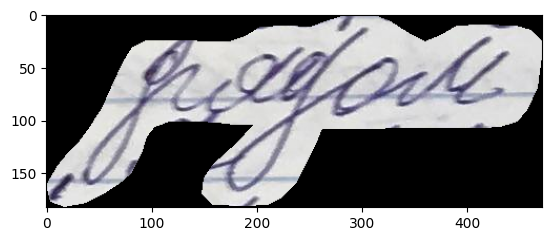

In [16]:
s = 'рядом'
plt.imshow(plt.imread(hack_data[hack_data['label'] == s].iloc[0]['image']))

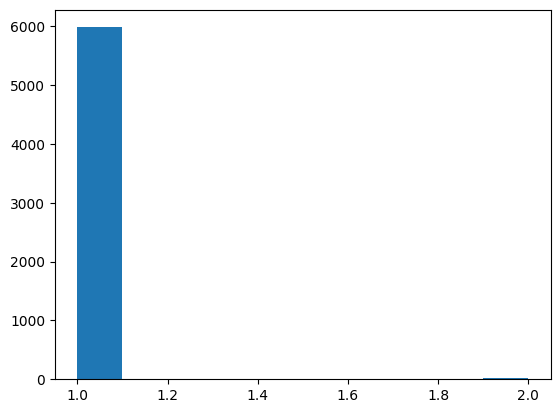

In [17]:
plt.hist([len(el.split()) for el in hack_data['label']])
plt.show()

# **Building VAL dataset**

In [18]:
hack_data.head()

,image,label,base_image
0,train_recognition_small/train_recognition_smal...,"дверку,",1_5.JPG
1,train_recognition_small/train_recognition_smal...,открыл,1_5.JPG
2,train_recognition_small/train_recognition_smal...,Я,1_5.JPG
3,train_recognition_small/train_recognition_smal...,хвостом.,1_5.JPG
4,train_recognition_small/train_recognition_smal...,вилял,1_5.JPG


In [18]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(hack_data, test_size=0.2, random_state=42, shuffle=True)

In [19]:
df_val.shape

(1201, 3)

In [20]:
df_val = df_val[['train_recognition_small' in el for el in df_val['image']]]

In [21]:
df_val.shape

(1201, 3)

In [22]:
def random_show(df):
  now = df.sample(1).iloc[0]
  img = plt.imread(now['image'])
  plt.imshow(img)
  plt.title(now['label'])
  plt.show()

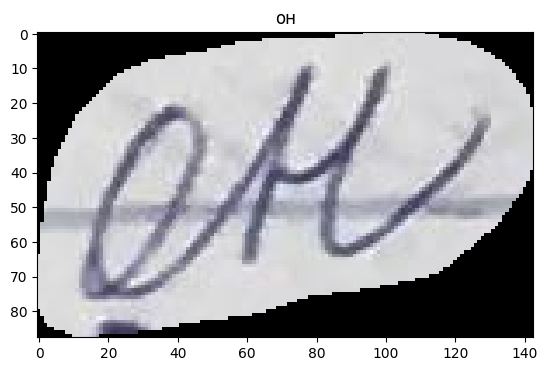

In [24]:
random_show(hack_data)

In [23]:
df_train.shape, df_val.shape

((4800, 3), (1201, 3))

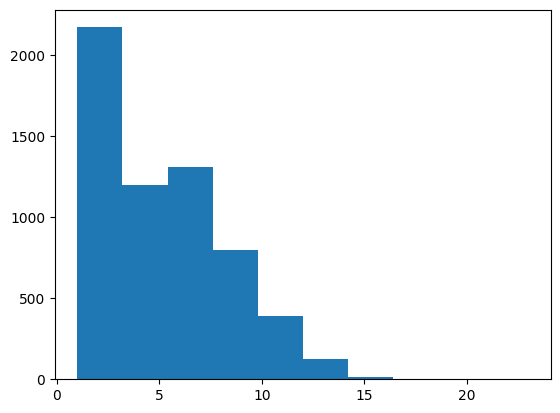

In [26]:
plt.hist(hack_data['label'].apply(lambda x: len(x)))
plt.show()

# **Define dataset**

In [24]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, transforms, tokenizer, feature_extractor, max_target_length=64):
        self.root_dir = root_dir
        self.df = df
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.max_target_length = max_target_length
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def _load_file(self, path):
      image = cv2.imread(path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      return image

    def __getitem__(self, idx):
        el = self.df.iloc[idx]
        file_name = el['image']
        text = el['label']

        image = self._load_file(os.path.join(self.root_dir, file_name))
        image = self.transforms(image=image)['image']

        pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values

        # add labels (input_ids) by encoding the text
        labels = self.tokenizer(text,
                                padding="max_length",
                                max_length=self.max_target_length).input_ids

        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [25]:
# from augmixations import HandWrittenBlot
from hwb import HandWrittenBlot
import albumentations as A


class AlbuHandWrittenBlot(A.DualTransform):
    def __init__(self, hwb, always_apply=False, p=0.5):
        super(AlbuHandWrittenBlot, self).__init__(always_apply, p)
        self.hwb = hwb

    def apply(self, image, **params):
        return self.hwb(image)


class AlbuPadding(A.DualTransform):
    def __init__(self, always_apply=False, p=0.5):
        super(AlbuPadding, self).__init__(always_apply, p)

    def apply(self, image, **params):
        zeros = np.zeros((128, 384, 3))
        image = np.concatenate([zeros, image, zeros], axis=0)
        return image.astype(np.uint8)

In [26]:
rectangle_info = {
    'x': (None, None),
    'y': (150, 220),
    'h': (60, 100),
    'w': (50, 80),
}

blot_params = {
    'incline': (-10, 10),
    'intensivity': (0.5, 0.9),
    'transparency': (0.05, 0.4),
    'count': (1, 3),
}

blots = HandWrittenBlot(rectangle_info, blot_params)

In [27]:
from albumentations.pytorch.transforms import ToTensorV2

data_transforms = {
    'train': A.Compose([
              A.Resize(128, 384),
              AlbuPadding(always_apply=True),
              AlbuHandWrittenBlot(blots, p=0.3),
              A.Rotate(limit=[-7, 7]),
              A.OneOf([
                A.ToGray(always_apply=True),
                A.CLAHE(always_apply=True, clip_limit=15),
              ], 0.3)
          ]),
    'val': A.Compose([
              A.Resize(128, 384),
              AlbuPadding(always_apply=True),
          ]),
}

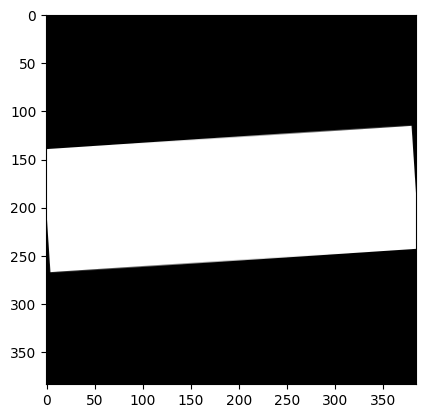

In [31]:
plt.imshow(data_transforms['train'](image=np.ones((140, 312, 3)) * 255)['image'])

# **Define model**

In [28]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import torch

# Загружаем модель и процессор
model = VisionEncoderDecoderModel.from_pretrained("raxtemur/trocr-base-ru")
processor = TrOCRProcessor.from_pretrained("raxtemur/trocr-base-ru")
# tokenizer = XLMRobertaTokenizer.from_pretrained('microsoft/trocr-small-handwritten')
feature_extractor = processor.feature_extractor
tokenizer = processor.tokenizer
model.eval()

config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/205 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (i

In [29]:
def set_requires_grad(model, value) :
  for param in model.parameters():
    param.requires_grad = value

In [30]:
model = model.to(device)

In [31]:
model.decoder.resize_token_embeddings(len(tokenizer))

# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id =  tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
# model.config.encoder.image_size = img_size
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [32]:
tokenizer.save_pretrained(os.path.join(PROJECT_DIR, 'ocr_models', f'trocr-{model_type}-handwritten-tokenizer'))
processor.save_pretrained(os.path.join(PROJECT_DIR, 'ocr_models', f'trocr-{model_type}-handwritten-feature-extractor'))

[]

# **Define loaders and try model**

In [33]:
from transformers import TrOCRProcessor

train_dataset = IAMDataset(root_dir='./',
                           df=df_train,
                           transforms=data_transforms['train'],
                           tokenizer=tokenizer,
                           feature_extractor=processor)

val_dataset = IAMDataset(root_dir='./',
                         df=df_val,
                         transforms=data_transforms['val'],
                         tokenizer=tokenizer,
                         feature_extractor=processor)

In [38]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 4800
Number of validation examples: 1201


In [34]:
from torch.utils.data import DataLoader
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16,)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=16,)

In [35]:
val_batch = next(iter(val_loader))
val_batch['pixel_values'].shape

torch.Size([8, 3, 384, 384])

In [36]:
for k, v in val_batch.items():
  val_batch[k] = v.to(device)

In [37]:
# %%time
y = model(**val_batch)

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


In [38]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.6 MB/s eta 0:00:00


In [39]:
import evaluate

cer_metric = evaluate.load("cer")

In [40]:
def compute_cer(pred_ids, label_ids):
    pred_ids = pred_ids.cpu().numpy()
    label_ids = label_ids.cpu().numpy()

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    res = cer_metric.compute(predictions=pred_str, references=label_str)
    if isinstance(res, dict):
        return res.get("cer", next(iter(res.values())))
    else:
        return res

# **Train model**

In [41]:
def plot_images(images_for_show):
  fig = plt.figure(figsize=(16, 16))

  columns = len(images_for_show)
  rows = 1
  for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.clip(images_for_show[i - 1], 0, 1))

  fig.subplots_adjust(wspace=0.1, hspace=0)
  plt.show()

In [42]:
def show_random_predict(model, test_loader, batch=None):
  """Выводит необходимую информацию после каждой эпохи"""
  if batch is None:
    batch = next(iter(test_loader))


  outputs = model.generate(batch["pixel_values"].to(device))
  now = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
  plot_images(torch.moveaxis(batch['pixel_values'][:4], 1, -1).detach().cpu().numpy())
  print([tokenizer.decode(pred.cpu().numpy(), skip_special_tokens=True) for pred in outputs[:4]])
  print([tokenizer.decode(el.cpu().numpy(), skip_special_tokens=True) for el in batch['labels'][:4]])

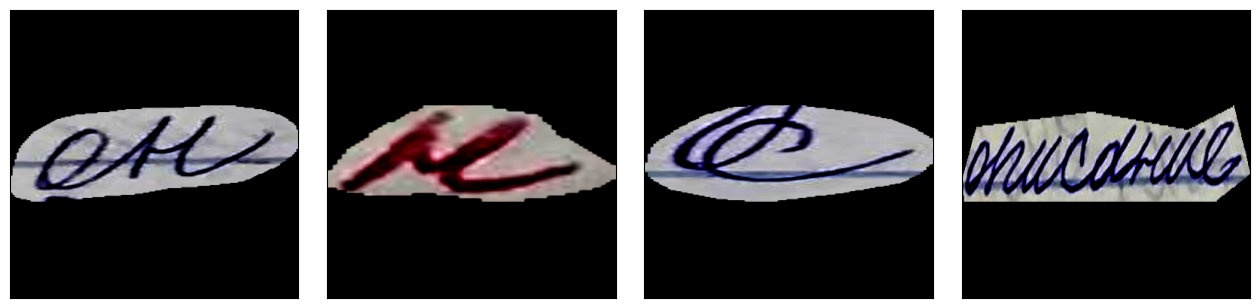

['он.', 'не', 'Б', 'описание']
['он', 'н', 'с', 'описание']


In [48]:
show_random_predict(model.train(True), val_loader)

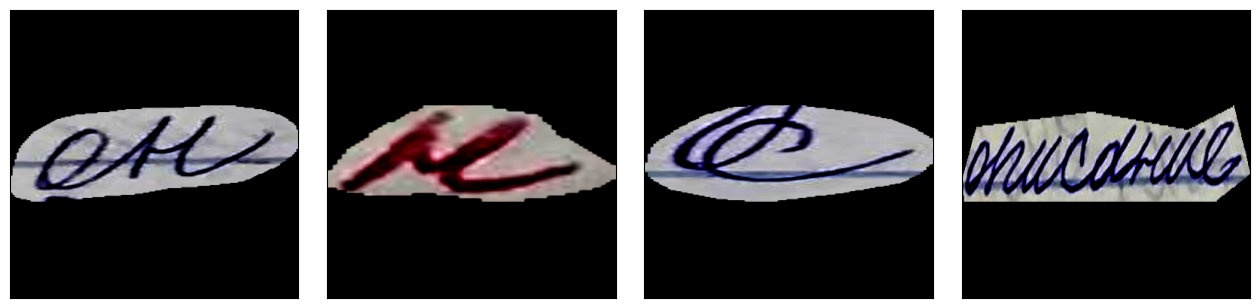

['он.', 'н,', 'Б', 'описание']
['он', 'н', 'с', 'описание']


In [49]:
show_random_predict(model.train(False), val_loader)

In [43]:
val_batch = next(iter(val_loader))
train_batch = next(iter(train_loader))

In [44]:
import time

def train_epoch(model, batch_gen, criterion, optimizer, is_train = True, full_cer = False) :
    epoch_loss = 0.0
    count = 0
    cer = 0.0
    cnt_batches = 0
    # model.train(True)
    model.train(is_train)

    for batch in tqdm(batch_gen) :
        start = time.time()
        cnt_batches += 1

        for k, v in batch.items():
            batch[k] = v.to(device)

        with torch.set_grad_enabled(is_train) :
            outputs = model(**batch)
            loss = outputs.loss

            if is_train :
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            count += 1
            epoch_loss += loss.item()

            if cnt_batches % 100 == 0 and is_train: # каждые 100 предсказаний выводим CER
                model.save_pretrained(f"/content/drive/MyDrive/ocr_models/tr_ocr_last_{model_type}")

                outputs = model.generate(val_batch["pixel_values"].to(device))
                now = compute_cer(pred_ids=outputs, label_ids=val_batch["labels"])
                s = 'val batch cer = ' + str(now) + ' '

                outputs = model.generate(train_batch["pixel_values"].to(device))
                now = compute_cer(pred_ids=outputs, label_ids=train_batch["labels"])
                print(s + 'train batch cer = ', now)


            if not is_train and full_cer:
              outputs = model.generate(batch["pixel_values"])
              now = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
              cer += now

    if full_cer:
      now = cer / count
    else:
      outputs = model.generate(val_batch["pixel_values"].to(device))
      now = compute_cer(pred_ids=outputs, label_ids=val_batch["labels"])

    return epoch_loss / count, now


In [45]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, verbose=True):
    loader = {'train': train_loader, 'test': test_loader}
    loss_history = {'train': [], 'test': []}
    cer_history = {'train': [], 'test': []}
    best_loss = 0.12595586647062199 # 0.6189

    for epoch in range(num_epochs):
        if verbose:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        for phase in ['train', 'test']:
            epoch_loss, epoch_cer = train_epoch(model, loader[phase], criterion, optimizer, phase == 'train', full_cer=False)
            if verbose:
                print('{} Loss: {:.4f} Cer: {:.4f}'.format(phase, epoch_loss, epoch_cer))
            loss_history[phase].append(epoch_loss)
            cer_history[phase].append(epoch_cer)

        if scheduler is not None:
            scheduler.step()

        if verbose:
            show_random_predict(model, test_loader, val_batch)
            print()

        if loss_history['test'][-1] < best_loss:
          best_loss = loss_history['test'][-1]
          print('updated best loss on {} epoch, now it {}'.format(epoch, best_loss))
          model.save_pretrained(f"/content/drive/MyDrive/ocr_models/tr_ocr_best_{model_type}")

    return loss_history, cer_history

In [53]:
epoch_loss, epoch_f1 = train_epoch(model, val_loader, None, None, False, True)
epoch_loss, epoch_f1

100%|██████████| 151/151 [09:44<00:00,  3.87s/it]


(18.22665755164544, 0.3603247469918082)

In [54]:
from torch.optim import lr_scheduler
optimizer = optim.Adam(model.parameters(), lr=3e-5)
lr_scheduler = None

Epoch 0/0
----------


 17%|█▋        | 100/600 [02:56<1:55:43, 13.89s/it]

val batch cer = 0.9459459459459459 train batch cer =  0.925


 33%|███▎      | 200/600 [05:22<41:15,  6.19s/it]

val batch cer = 0.6756756756756757 train batch cer =  0.85


 50%|█████     | 300/600 [07:53<36:34,  7.31s/it]

val batch cer = 0.8108108108108109 train batch cer =  0.975


 67%|██████▋   | 400/600 [10:20<21:19,  6.40s/it]

val batch cer = 0.7297297297297297 train batch cer =  0.95


 83%|████████▎ | 500/600 [12:52<13:23,  8.03s/it]

val batch cer = 1.135135135135135 train batch cer =  1.225


100%|██████████| 600/600 [15:20<00:00,  6.63s/it]

val batch cer = 1.054054054054054 train batch cer =  0.925


100%|██████████| 600/600 [15:21<00:00,  1.54s/it]


train Loss: 1.0894 Cer: 0.9189


100%|██████████| 151/151 [01:08<00:00,  2.21it/s]


test Loss: 0.3689 Cer: 1.0811


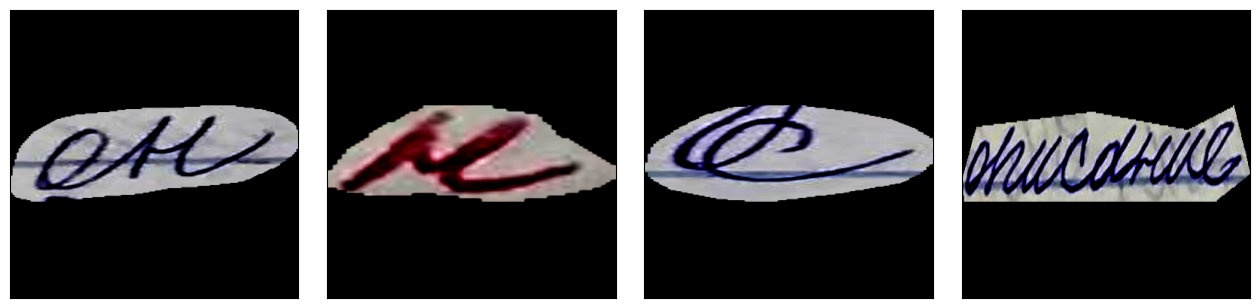

['о', 'н�ннн', 'ос', 'о�иаи']
['он', 'н', 'с', 'описание']



In [55]:
loss_history, cer_history = train_model(model, train_loader, val_loader, lr_scheduler, optimizer, None, 1)

In [56]:
import torch
torch.cuda.empty_cache()

Epoch 0/4
----------


 17%|█▋        | 100/600 [02:37<1:04:41,  7.76s/it]

val batch cer = 1.162162162162162 train batch cer =  0.975


 33%|███▎      | 200/600 [05:07<46:35,  6.99s/it]

val batch cer = 0.9459459459459459 train batch cer =  1.35


 50%|█████     | 300/600 [07:35<33:35,  6.72s/it]

val batch cer = 0.972972972972973 train batch cer =  0.875


 67%|██████▋   | 400/600 [10:03<22:19,  6.70s/it]

val batch cer = 0.6216216216216216 train batch cer =  1.0


 83%|████████▎ | 500/600 [12:36<13:32,  8.12s/it]

val batch cer = 1.2162162162162162 train batch cer =  0.925


100%|██████████| 600/600 [15:12<00:00,  9.26s/it]

val batch cer = 1.0 train batch cer =  0.9


100%|██████████| 600/600 [15:13<00:00,  1.52s/it]


train Loss: 0.2867 Cer: 1.0811


100%|██████████| 151/151 [01:08<00:00,  2.21it/s]


test Loss: 0.3677 Cer: 1.0000


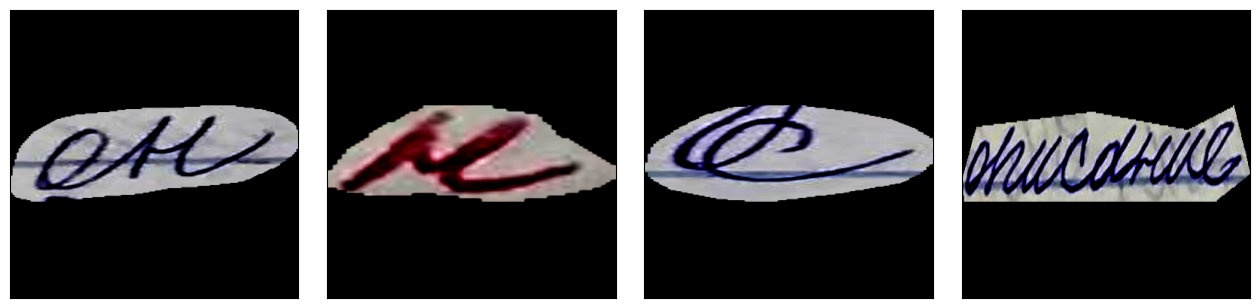

['о', 'н', 'с��', 'о�иаи']
['он', 'н', 'с', 'описание']

Epoch 1/4
----------


 17%|█▋        | 100/600 [02:37<1:05:46,  7.89s/it]

val batch cer = 1.2702702702702702 train batch cer =  0.9


 33%|███▎      | 200/600 [05:08<49:20,  7.40s/it]

val batch cer = 1.027027027027027 train batch cer =  0.875


 50%|█████     | 300/600 [07:35<31:31,  6.30s/it]

val batch cer = 0.7567567567567568 train batch cer =  1.025


 67%|██████▋   | 400/600 [10:14<33:25, 10.03s/it]

val batch cer = 1.2162162162162162 train batch cer =  1.15


 83%|████████▎ | 500/600 [12:46<12:50,  7.70s/it]

val batch cer = 0.8918918918918919 train batch cer =  0.85


100%|██████████| 600/600 [15:15<00:00,  7.00s/it]

val batch cer = 0.8648648648648649 train batch cer =  0.875


100%|██████████| 600/600 [15:16<00:00,  1.53s/it]


train Loss: 0.1891 Cer: 0.8919


100%|██████████| 151/151 [01:07<00:00,  2.22it/s]


test Loss: 0.3281 Cer: 1.0811


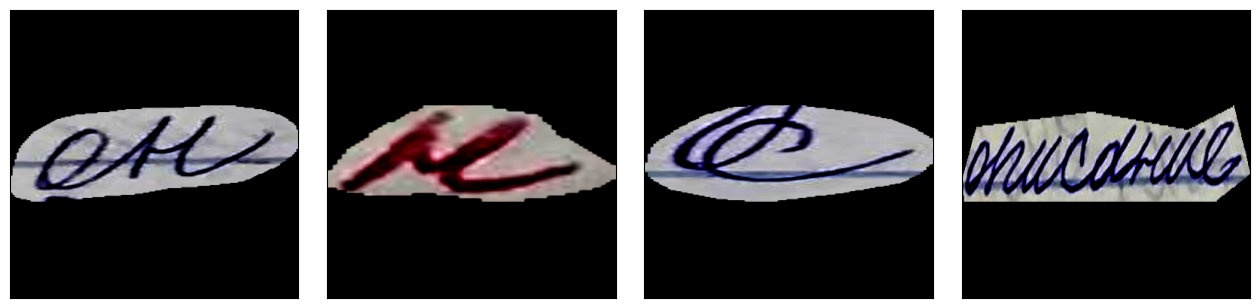

['о', 'н', 'сс', 'о�иаие']
['он', 'н', 'с', 'описание']

Epoch 2/4
----------


 17%|█▋        | 100/600 [02:34<57:40,  6.92s/it]

val batch cer = 0.8918918918918919 train batch cer =  0.75


 33%|███▎      | 200/600 [05:05<50:04,  7.51s/it]

val batch cer = 0.8108108108108109 train batch cer =  0.95


 50%|█████     | 300/600 [07:44<48:25,  9.68s/it]

val batch cer = 0.918918918918919 train batch cer =  1.05


 67%|██████▋   | 400/600 [10:16<26:35,  7.98s/it]

val batch cer = 0.7567567567567568 train batch cer =  0.95


 83%|████████▎ | 500/600 [12:56<16:32,  9.92s/it]

val batch cer = 0.7837837837837838 train batch cer =  0.9


100%|██████████| 600/600 [15:27<00:00,  7.59s/it]

val batch cer = 1.2162162162162162 train batch cer =  0.975


100%|██████████| 600/600 [15:27<00:00,  1.55s/it]


train Loss: 0.1187 Cer: 1.0541


100%|██████████| 151/151 [01:07<00:00,  2.23it/s]


test Loss: 0.4350 Cer: 1.2432


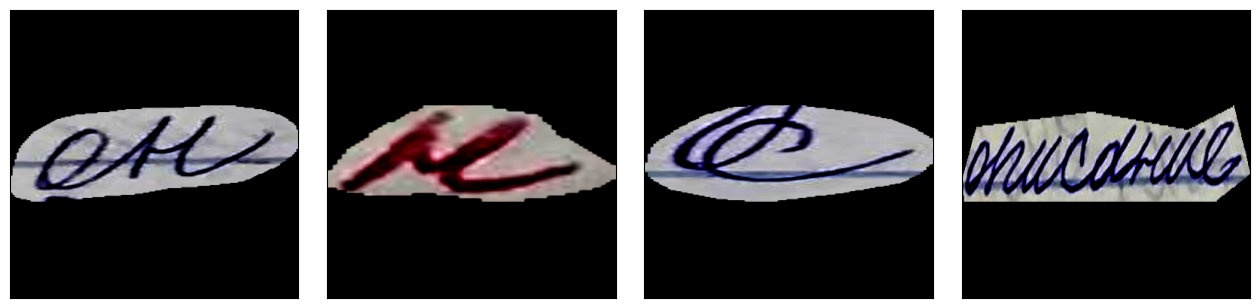

['о', 'н', 'ссс�с��ссос', 'о�иаииене']
['он', 'н', 'с', 'описание']

Epoch 3/4
----------


 17%|█▋        | 100/600 [02:38<1:08:50,  8.26s/it]

val batch cer = 0.8108108108108109 train batch cer =  0.9


 33%|███▎      | 200/600 [05:17<1:04:26,  9.67s/it]

val batch cer = 0.7567567567567568 train batch cer =  0.825


 50%|█████     | 300/600 [08:08<1:07:33, 13.51s/it]

val batch cer = 1.054054054054054 train batch cer =  0.825


 67%|██████▋   | 400/600 [10:44<29:33,  8.87s/it]

val batch cer = 0.9459459459459459 train batch cer =  0.925


 83%|████████▎ | 500/600 [13:19<14:38,  8.79s/it]

val batch cer = 0.8378378378378378 train batch cer =  0.725


100%|██████████| 600/600 [15:50<00:00,  7.23s/it]

val batch cer = 0.8648648648648649 train batch cer =  0.975


100%|██████████| 600/600 [15:50<00:00,  1.58s/it]


train Loss: 0.1179 Cer: 0.9189


100%|██████████| 151/151 [01:09<00:00,  2.17it/s]


test Loss: 0.4005 Cer: 0.8378


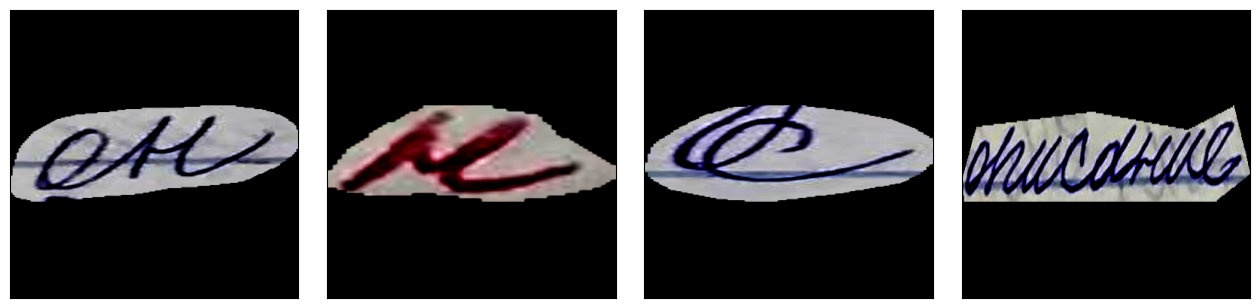

['о', 'н', 'с', 'о�иане']
['он', 'н', 'с', 'описание']

Epoch 4/4
----------


 17%|█▋        | 100/600 [02:36<1:04:45,  7.77s/it]

val batch cer = 0.8378378378378378 train batch cer =  0.925


 33%|███▎      | 200/600 [05:22<1:19:57, 11.99s/it]

val batch cer = 0.7837837837837838 train batch cer =  0.825


 50%|█████     | 300/600 [07:52<35:09,  7.03s/it]

val batch cer = 0.8918918918918919 train batch cer =  0.7


 67%|██████▋   | 400/600 [10:22<24:14,  7.27s/it]

val batch cer = 0.918918918918919 train batch cer =  1.025


 73%|███████▎  | 440/600 [11:15<03:29,  1.31s/it]

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=5e-5)
loss_history, cer_history = train_model(model, train_loader, val_loader, None, optimizer, None, 3)

In [ ]:
# from torch.optim.lr_scheduler import StepLR
# optimizer = optim.Adam(model.parameters(), lr=5e-5)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

Epoch 0/9
----------


 17%|█▋        | 100/600 [03:04<1:56:03, 13.93s/it]

val batch cer = 0.40540540540540543 train batch cer =  0.30952380952380953


 33%|███▎      | 200/600 [05:36<36:47,  5.52s/it]

val batch cer = 0.40540540540540543 train batch cer =  0.2619047619047619


 50%|█████     | 300/600 [08:13<37:02,  7.41s/it]

val batch cer = 0.24324324324324326 train batch cer =  0.23809523809523808


 67%|██████▋   | 400/600 [11:00<34:16, 10.28s/it]

val batch cer = 0.3783783783783784 train batch cer =  0.2619047619047619


 83%|████████▎ | 500/600 [13:52<19:33, 11.74s/it]

val batch cer = 0.40540540540540543 train batch cer =  0.35714285714285715


100%|██████████| 600/600 [16:38<00:00,  9.93s/it]

val batch cer = 0.24324324324324326 train batch cer =  0.30952380952380953


100%|██████████| 600/600 [16:39<00:00,  1.67s/it]


train Loss: 17.1996 Cer: 0.3784


100%|██████████| 151/151 [01:11<00:00,  2.10it/s]


test Loss: 18.2267 Cer: 0.4054


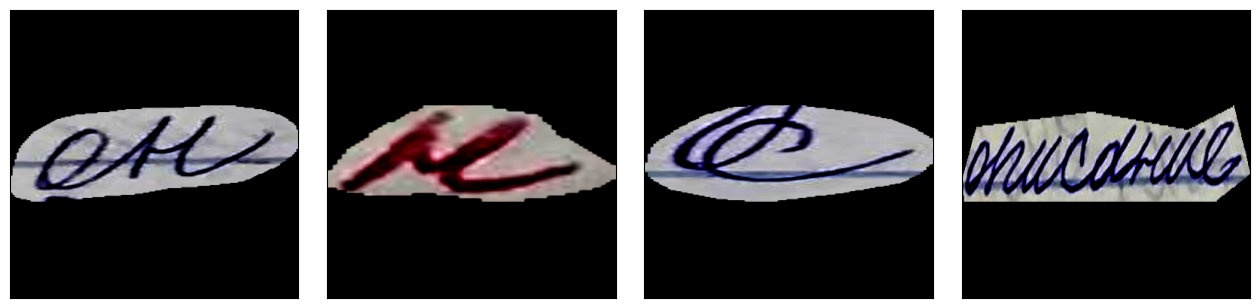

['он.', 'н,', 'Б', 'описание']
['он', 'н', 'с', 'описание']

Epoch 1/9
----------


 17%|█▋        | 100/600 [03:11<2:01:25, 14.57s/it]

val batch cer = 0.24324324324324326 train batch cer =  0.3333333333333333


 33%|███▎      | 200/600 [06:05<1:13:22, 11.01s/it]

val batch cer = 0.4594594594594595 train batch cer =  0.2857142857142857


 50%|█████     | 300/600 [09:30<1:41:22, 20.27s/it]

val batch cer = 0.24324324324324326 train batch cer =  0.30952380952380953


 67%|██████▋   | 400/600 [12:16<28:40,  8.60s/it]

val batch cer = 0.3783783783783784 train batch cer =  0.2857142857142857


 83%|████████▎ | 500/600 [15:30<28:17, 16.98s/it]

val batch cer = 0.3783783783783784 train batch cer =  0.30952380952380953


100%|██████████| 600/600 [18:35<00:00, 14.10s/it]

val batch cer = 0.43243243243243246 train batch cer =  0.40476190476190477


100%|██████████| 600/600 [18:36<00:00,  1.86s/it]


train Loss: 15.2968 Cer: 0.4324


100%|██████████| 151/151 [01:15<00:00,  2.01it/s]


test Loss: 14.2127 Cer: 0.4324


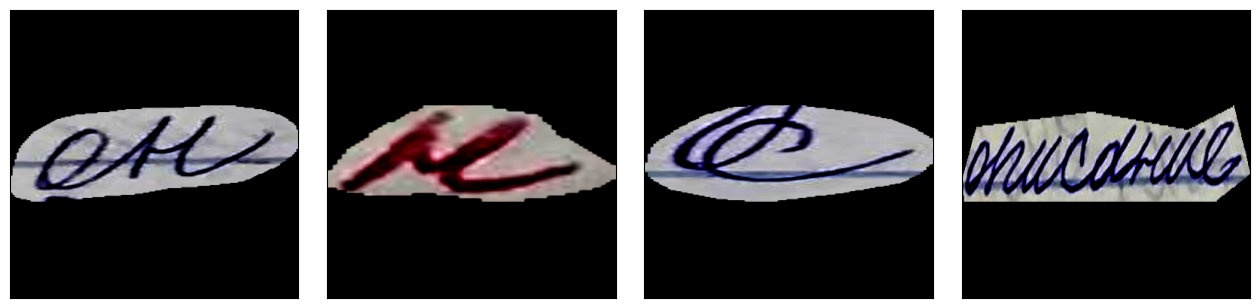

['ею', 'н', 'Б', 'описание']
['он', 'н', 'с', 'описание']

Epoch 2/9
----------


 17%|█▋        | 100/600 [03:26<2:28:41, 17.84s/it]

val batch cer = 0.4864864864864865 train batch cer =  0.40476190476190477


 33%|███▎      | 200/600 [06:41<1:54:18, 17.15s/it]

val batch cer = 0.43243243243243246 train batch cer =  0.5


 50%|█████     | 300/600 [09:56<1:26:12, 17.24s/it]

val batch cer = 0.43243243243243246 train batch cer =  0.4523809523809524


 67%|██████▋   | 400/600 [13:08<54:03, 16.22s/it]

val batch cer = 0.4864864864864865 train batch cer =  0.5714285714285714


 83%|████████▎ | 500/600 [15:55<14:41,  8.82s/it]

val batch cer = 0.5945945945945946 train batch cer =  0.7142857142857143


100%|██████████| 600/600 [18:44<00:00,  9.50s/it]

val batch cer = 0.6486486486486487 train batch cer =  0.7380952380952381


100%|██████████| 600/600 [18:45<00:00,  1.88s/it]


train Loss: 9.8035 Cer: 0.6216


100%|██████████| 151/151 [01:15<00:00,  2.01it/s]


test Loss: 7.1099 Cer: 0.6216


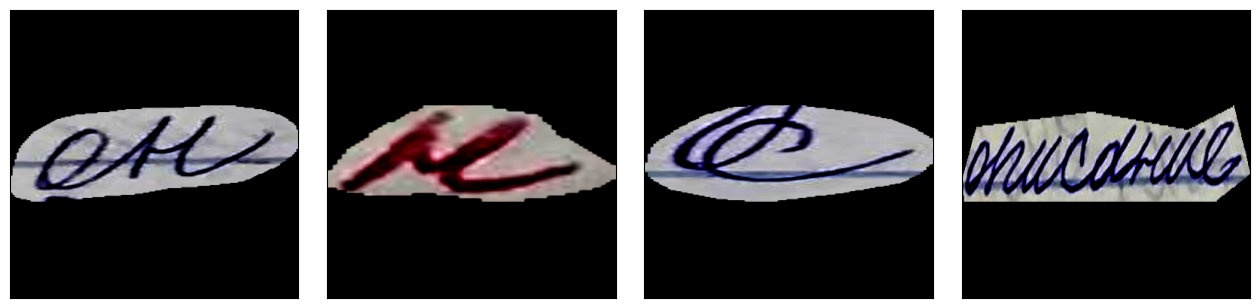

['ею', '�н', '�с', 'описание']
['он', 'н', 'с', 'описание']

Epoch 3/9
----------


 17%|█▋        | 100/600 [03:16<2:09:07, 15.50s/it]

val batch cer = 0.6756756756756757 train batch cer =  0.7619047619047619


 33%|███▎      | 200/600 [06:17<1:26:00, 12.90s/it]

val batch cer = 0.918918918918919 train batch cer =  0.8571428571428571


 50%|█████     | 300/600 [09:31<1:25:10, 17.04s/it]

val batch cer = 0.9459459459459459 train batch cer =  0.8571428571428571


 67%|██████▋   | 400/600 [12:14<24:28,  7.34s/it]

val batch cer = 1.027027027027027 train batch cer =  0.8571428571428571


 83%|████████▎ | 500/600 [15:15<21:26, 12.86s/it]

val batch cer = 1.0 train batch cer =  0.9761904761904762


100%|██████████| 600/600 [18:05<00:00,  9.75s/it]

val batch cer = 0.972972972972973 train batch cer =  0.9285714285714286


100%|██████████| 600/600 [18:06<00:00,  1.81s/it]


train Loss: 5.0151 Cer: 0.9730


100%|██████████| 151/151 [01:15<00:00,  2.00it/s]


test Loss: 3.7573 Cer: 1.0000


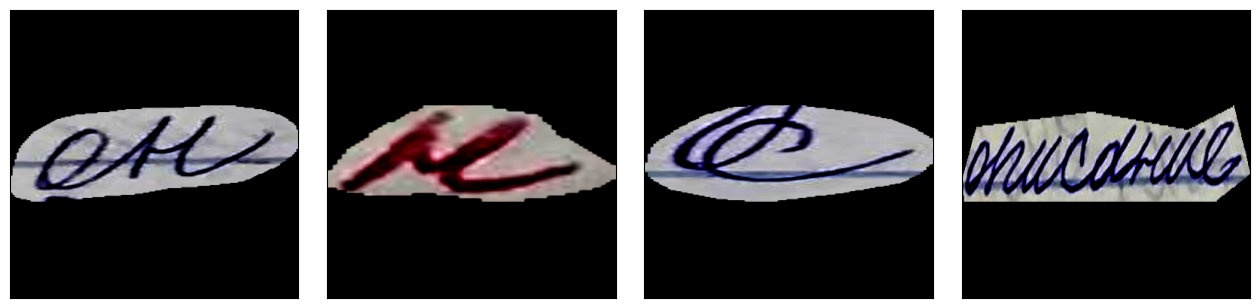

['�', '', '', '�']
['он', 'н', 'с', 'описание']

Epoch 4/9
----------


 17%|█▋        | 100/600 [03:15<2:10:54, 15.71s/it]

val batch cer = 0.9459459459459459 train batch cer =  0.9285714285714286


 33%|███▎      | 200/600 [06:27<1:47:50, 16.18s/it]

val batch cer = 1.0 train batch cer =  0.9761904761904762


 50%|█████     | 300/600 [09:44<1:29:23, 17.88s/it]

val batch cer = 0.972972972972973 train batch cer =  1.0714285714285714


 67%|██████▋   | 400/600 [13:03<1:01:32, 18.46s/it]

val batch cer = 0.9459459459459459 train batch cer =  1.1428571428571428


 83%|████████▎ | 500/600 [16:17<27:48, 16.68s/it]

val batch cer = 1.0 train batch cer =  0.9523809523809523


100%|██████████| 600/600 [19:17<00:00, 12.70s/it]

val batch cer = 0.972972972972973 train batch cer =  1.0


100%|██████████| 600/600 [19:18<00:00,  1.93s/it]


train Loss: 3.6609 Cer: 0.9730


100%|██████████| 151/151 [01:17<00:00,  1.96it/s]


test Loss: 3.5073 Cer: 1.0000


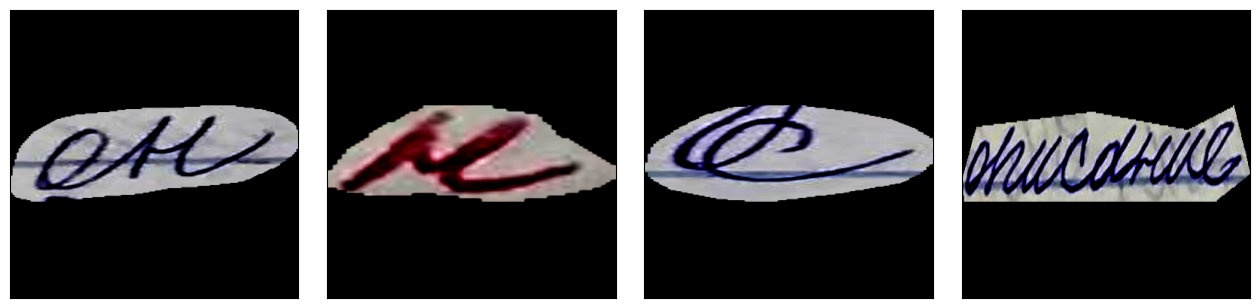

['�', '', '�', '�']
['он', 'н', 'с', 'описание']

Epoch 5/9
----------


 17%|█▋        | 100/600 [03:19<2:18:27, 16.62s/it]

val batch cer = 0.972972972972973 train batch cer =  1.3571428571428572


 33%|███▎      | 200/600 [06:43<2:11:58, 19.80s/it]

val batch cer = 1.0 train batch cer =  1.2619047619047619


 50%|█████     | 300/600 [09:45<1:06:40, 13.34s/it]

val batch cer = 0.9459459459459459 train batch cer =  1.3571428571428572


 67%|██████▋   | 400/600 [12:58<54:56, 16.48s/it]

val batch cer = 0.9459459459459459 train batch cer =  1.3095238095238095


 83%|████████▎ | 500/600 [16:12<28:01, 16.81s/it]

val batch cer = 0.972972972972973 train batch cer =  1.2380952380952381


100%|██████████| 600/600 [19:25<00:00, 16.35s/it]

val batch cer = 0.9459459459459459 train batch cer =  2.142857142857143


100%|██████████| 600/600 [19:26<00:00,  1.94s/it]


train Loss: 3.5403 Cer: 0.9459


100%|██████████| 151/151 [01:15<00:00,  2.00it/s]


test Loss: 3.4284 Cer: 0.9730


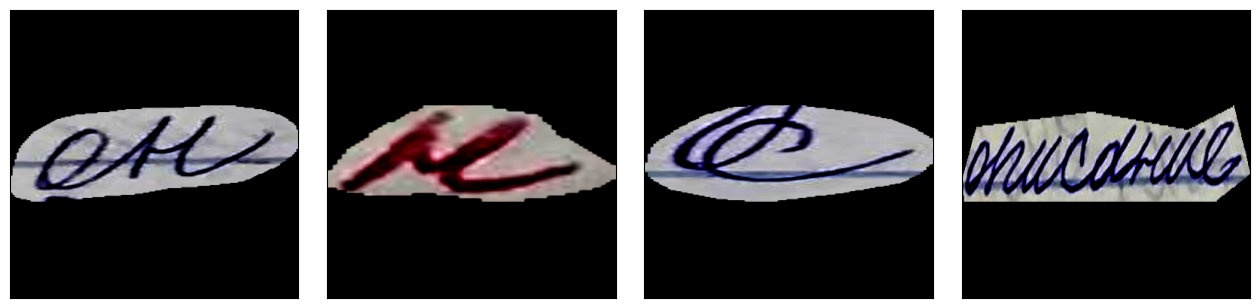

['�', '', '', '�']
['он', 'н', 'с', 'описание']

Epoch 6/9
----------


 17%|█▋        | 100/600 [03:17<2:14:45, 16.17s/it]

val batch cer = 0.972972972972973 train batch cer =  1.4761904761904763


 33%|███▎      | 200/600 [06:44<2:19:26, 20.92s/it]

val batch cer = 0.918918918918919 train batch cer =  2.0


 50%|█████     | 300/600 [09:44<1:03:44, 12.75s/it]

val batch cer = 0.8918918918918919 train batch cer =  1.3333333333333333


 67%|██████▋   | 400/600 [12:59<56:17, 16.89s/it]

val batch cer = 0.8918918918918919 train batch cer =  1.619047619047619


 75%|███████▍  | 448/600 [14:09<04:48,  1.90s/it]


KeyboardInterrupt: 

In [51]:
from torch.optim import AdamW
from transformers import get_scheduler

optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)
scheduler = get_scheduler("linear", optimizer=optimizer,
                          num_warmup_steps=500,
                          num_training_steps=len(train_loader) * 10) #10 = num_epochs

loss_history, cer_history = train_model(model, train_loader, val_loader, None, optimizer, scheduler, 10)